# ENCODE Long Read Sequel2 dataset

This tutorial guides through a typical Long Read Transcriptome Sequencing (LRTS) analysis workflow with isotools, 
using ENCODE Isoseq Sequel2 Data. It demonstrates the analysis of alternative splicing events within and between sample groups. 

The original analysis integrates quite a large number of samples, and consequently runs several hours. Users interested in reproducing the notebook should consider restricting the data to the samples they are interested in.

## Preparation
Select the "long read RNA-seq" samples in the ENCODE data portal (https://www.encodeproject.org/) and download aligned .bam files. Here I use all Sequel II samples available at the time of writing, but you choose to process a subset.
Download the files with curl and use samtools to index the bam files.
``` sh
xargs -L 1 curl -O -J -L < ENCODE_files.txt
for bam in *bam; 
    do samtools index $bam
done
```

In addition to the bamfiles, a file metadata.tsv should have been downloaded, which we use to read the sample information. Further you need a reference annotation and a genome fastq file. Please see the Alzheimer tutorial how to get these files. 

## Data import

In [1]:

from  isotools import Transcriptome
from isotools import __version__ as isotools_version
print(f'This is isootools version {isotools_version}')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from collections import Counter

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')


This is isootools version 0.1.5rc2


In [2]:
#I assume the encode data (e.g. the bam files) are in an subdirctory "encode"

#first, process the metadata
metadata_link="https://www.encodeproject.org/metadata/?type=Experiment&assay_title=long+read+RNA-seq&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&files.file_type=bam&files.file_type=fastq&advancedQuery=date_released%3A%5B2009-02-01+TO+2021-12-31%5D&searchTerm=long+read+RNA-seq"
metadata=pd.read_csv(metadata_link, sep='\t')
platform=metadata.set_index('Experiment accession').Platform.dropna().to_dict()
for pf,count in Counter(platform.values()).items():
    print(f'{pf}: {count} samples from ENCODE')

#Select the samples from the metadata, make sure there are only bam files are in the table
samples=metadata[(metadata['Output type']=='alignments') & (metadata['File Status']=='released')].copy()
samples['Platform']=[platform.get(ea,'unknown') for ea in samples['Experiment accession']] #This info is missing for some files
samples=samples[['File accession','Output type','Biosample term name','Biosample type','Technical replicate(s)','Platform']].reset_index(drop=True) 
#we select all all SequelII files - adjust this as needed
samples=samples[samples.Platform=='Pacific Biosciences Sequel II'].reset_index(drop=True) 

#additional infos about the samples
infos=pd.read_csv('encode_samples.tsv', sep='\t').set_index('sample term')


chrom=[f'chr{i+1}'for i in range(22)]+['chrX','chrY']
#ENCODE uses an interesting reference, including sequences from viruses
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'

#check that all selected files have been downloaded and indexed, and that they can be found in the right folder
notfound=[]
for accession in samples['File accession']:
    if not os.path.isfile(f"encode/{accession}.bam"):
        logger.warning(f'bam file not found for {accession}')
    elif not os.path.isfile(f"encode/{accession}.bam"):
        logger.warning(f'bam index not found for {accession}')
    else:
        continue
    notfound.append(accession)
        
#print the sample table
samples

Pacific Biosciences Sequel II: 51 samples from ENCODE
Pacific Biosciences Sequel: 16 samples from ENCODE
Oxford Nanopore MinION: 5 samples from ENCODE


File accession Output type                    Biosample term name  \
0     ENCFF239CWJ  alignments                                 kidney   
1     ENCFF305AFY  alignments                  heart right ventricle   
2     ENCFF779VVX  alignments                lower lobe of left lung   
3     ENCFF322UJU  alignments                                   K562   
4     ENCFF660UTF  alignments                  heart right ventricle   
5     ENCFF118JEI  alignments                                  MCF-7   
6     ENCFF018PZX  alignments                  heart right ventricle   
7     ENCFF219UJG  alignments                                GM12878   
8     ENCFF193WEX  alignments                           psoas muscle   
9     ENCFF502LAB  alignments                   heart left ventricle   
10    ENCFF745DHX  alignments                                  Panc1   
11    ENCFF623IBV  alignments                   heart left ventricle   
12    ENCFF661OEY  alignments                                   K562   
13    ENCFF645UVN  alignments                                   K562   
14    ENCFF925MYC  alignments                              osteocyte   
15    ENCFF558QPF  alignments                              osteocyte   
16    ENCFF973OML  alignments                 type B pancreatic cell   
17    ENCFF058HQU  alignments                 type B pancreatic cell   
18    ENCFF132YCF  alignments     left ventricle myocardium inferior   
19    ENCFF173JOL  alignments    Right ventricle myocardium inferior   
20    ENCFF850YMO  alignments     left ventricle myocardium superior   
21    ENCFF767KXS  alignments               lower lobe of right lung   
22    ENCFF693YCD  alignments                    posterior vena cava   
23    ENCFF171AQO  alignments             mucosa of descending colon   
24    ENCFF745HHL  alignments                                  aorta   
25    ENCFF971JDY  alignments                     mesenteric fat pad   
26    ENCFF509GHY  alignments  progenitor cell of endocrine pancreas   
27    ENCFF803KIA  alignments  progenitor cell of endocrine pancreas   
28    ENCFF319JFG  alignments                      neural crest cell   
29    ENCFF901XCR  alignments                      neural crest cell   
30    ENCFF291EKY  alignments                   right cardiac atrium   
31    ENCFF344KQF  alignments                    left cardiac atrium   
32    ENCFF099TJN  alignments                                  aorta   
33    ENCFF626QRV  alignments                         cardiac septum   
34    ENCFF810FRP  alignments                                  HL-60   
35    ENCFF600MGT  alignments                                  HL-60   
36    ENCFF449MVA  alignments               upper lobe of right lung   
37    ENCFF044LIA  alignments                                   PC-3   
38    ENCFF936VUF  alignments                        endodermal cell   
39    ENCFF939EUU  alignments                        endodermal cell   
40    ENCFF400LRT  alignments                                 HCT116   
41    ENCFF545PJV  alignments                                 IMR-90   
42    ENCFF924HBV  alignments                lower lobe of left lung   
43    ENCFF583MSU  alignments                                  ovary   
44    ENCFF292UIE  alignments                                     H9   
45    ENCFF738RAA  alignments                                     H9   
46    ENCFF437SYY  alignments                   heart left ventricle   
47    ENCFF911RNV  alignments                   right cardiac atrium   
48    ENCFF472TSL  alignments                    posterior vena cava   
49    ENCFF814ABW  alignments                                  HepG2   
50    ENCFF875QHC  alignments                   right cardiac atrium   
51    ENCFF886FZQ  alignments                             left colon   
52    ENCFF613SDS  alignments                   right cardiac atrium   
53    ENCFF984RMR  alignments                                  ovary   
54    ENCFF840OVC  alignments    Right vent

In [ ]:
cols_of_interest=['cell', 'lineage', 'organ', 'karyotype']
try:    
    isoseq=Transcriptome(f'encode/encode_isotools.pkl')
except FileNotFoundError:
    try:
        isoseq=Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        isoseq=Transcriptome.from_reference(anno+'.gff3.gz')
        isoseq.save_reference(anno+'.isotools.pkl')
    for i,row in samples.iterrows():
        if row['File accession'] in notfound:
            continue
        sname=f"{row['Biosample term name']}_{row['Technical replicate(s)']}".replace(' ','_')
        if sname in isoseq.samples:
            l=ord('b')
            while f'{sname}_{l:c}' in isoseq.samples:
                l+=1
            sname=f'{sname}_{l:c}'
        cell_infos=infos.loc[row['Biosample term name'], cols_of_interest].to_dict()
        
        isoseq.add_sample_from_bam(f"encode/{row['File accession']}.bam", 
                                   use_satag=True,
                                   sample_name=sname , 
                                   group=row['Biosample term name'] ,
                                   sample_type=row['Biosample type'],
                                   platform=row['Platform'], **cell_infos) 
    isoseq.add_qc_metrics(genome) #3:41 min
    isoseq.make_index()
    isoseq.save('encode/encode_isotools.pkl')


INFO:loading transcriptome from encode/encode_isotoolsXXXX.pkl
INFO:importing reference from pkl file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotools.pkl
INFO:adding sample heart_left_ventricle_1_1 from file encode/ENCFF437SYY.bam
100%|██████████| 2576140.0/2576140 [07:40<00:00, 5590.50reads/s, chr=ERCC-00171]             
INFO:imported 2986 chimeric alignments that can be chained to single nonchimeric transcripts (long intron alingment split)
INFO:ignoring 7777 chimeric alignments with less than 2 reads
INFO:imported 2565890 nonchimeric reads (including  2986 chained chimeric alignments) and 1534 chimeric reads with coverage of at least 2.
INFO:adding sample HepG2_1_1 from file encode/ENCFF814ABW.bam
100%|██████████| 2516897.0/2516897 [07:50<00:00, 5354.97reads/s, chr=ERCC-00171]              
INFO:imported 2497 chimeric alignments that can be chained to single nonchimeric transcripts (long intron alingment split)
INFO:ignoring 55500 chimeric alignments with less

## Quality control and filtering
First, we will depict some quality metrics and define filtering criteria. For more information on techical artefacts, quality metrics, and filtering, see the Alzheimer tutorial. 

In [5]:
from isotools import DEFAULT_GENE_FILTER, DEFAULT_TRANSCRIPT_FILTER,DEFAULT_REF_TRANSCRIPT_FILTER
#add gencode specific filters
ref_filter=DEFAULT_REF_TRANSCRIPT_FILTER
ref_filter['HIGH_SUPPORT']='transcript_support_level=="1"'
ref_filter['PROTEIN_CODING']='transcript_type=="protein_coding"'

isoseq.add_filter( ref_transcript_filter=ref_filter)


100%|██████████| 570107/570107 [01:09<00:00, 8158.75it/s] 


In [6]:
#compute some summary statistics on technical artifacts. 
# For this analysis samples are grouped by 'Biosample term name'
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( remove=['NOVEL_GENE']), ref_filter=dict(include=['HIGH_SUPPORT'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( remove=['NOVEL_GENE', 'UNSPLICED']), ref_filter=dict(remove=['UNSPLICED'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(include=['NOVEL_GENE', 'UNSPLICED'])),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))

#statistic on the filter flags
f_stats=isoseq.filter_stats( groups=isoseq.groups(), weight_by_coverage=True,min_coverage=1)
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

INFO:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:NumExpr defaulting to 8 threads.


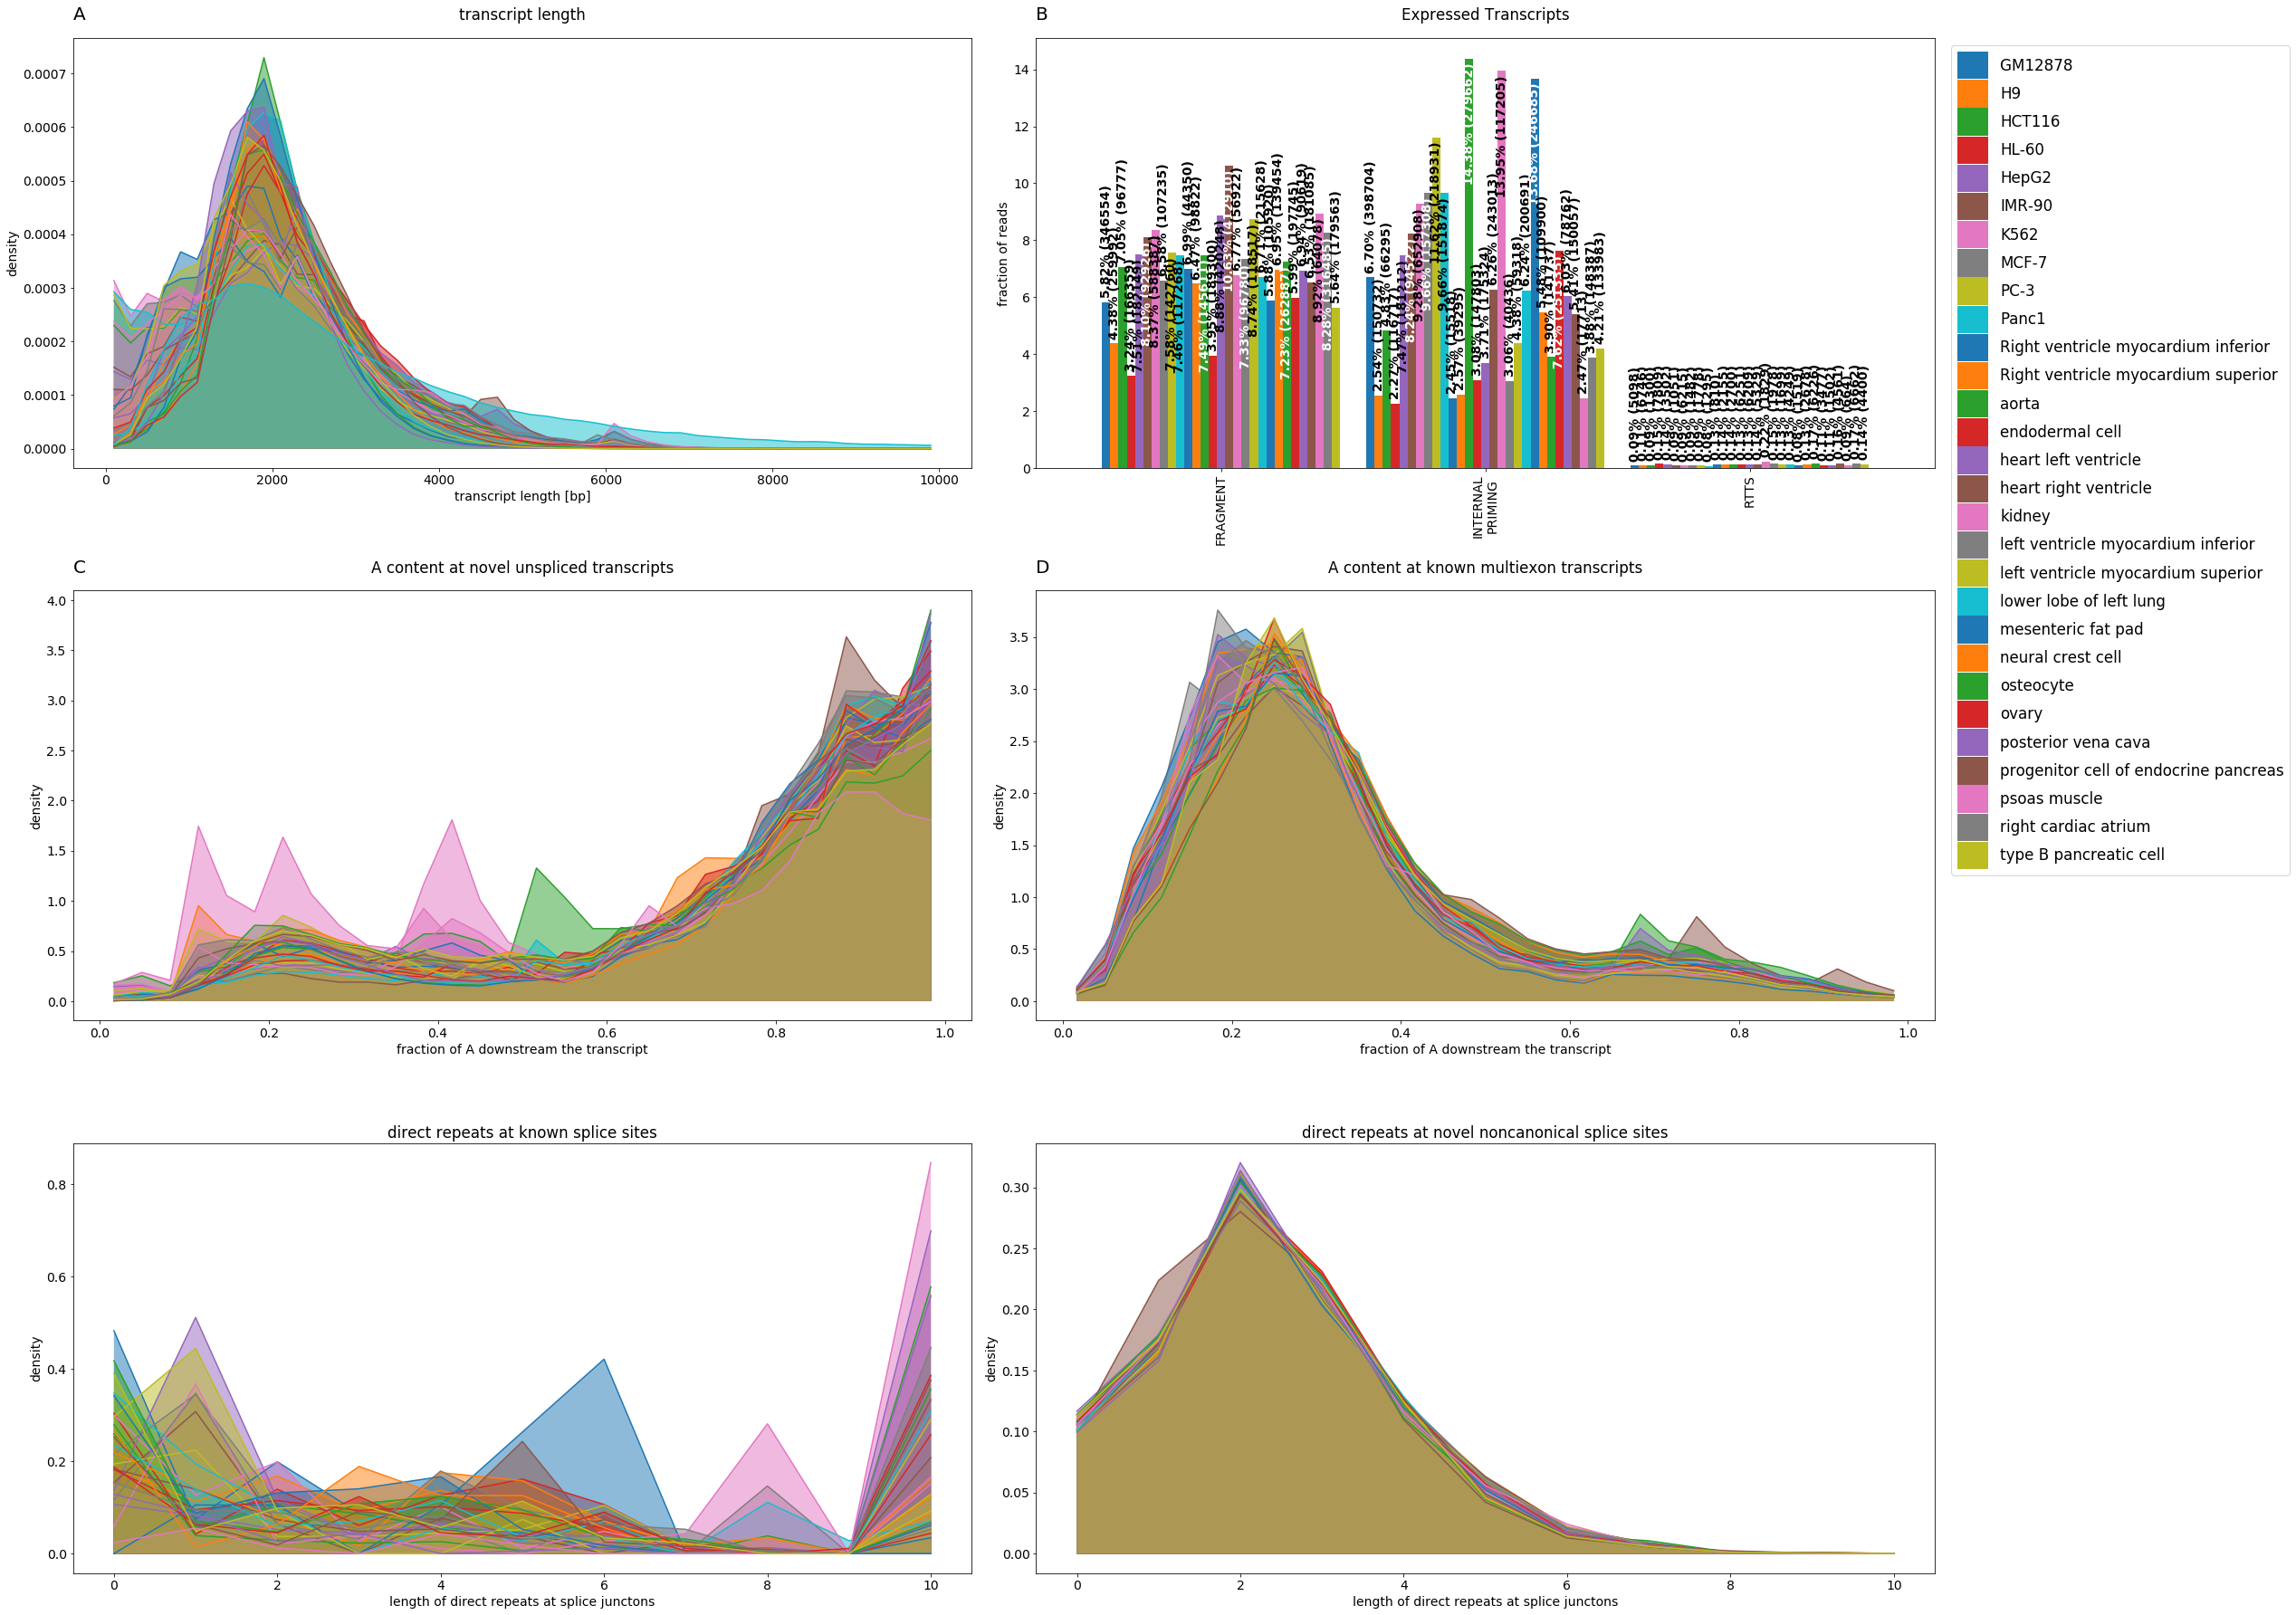

In [7]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],legend=False,**tr_stats[0][1])  
#D) frequency of artifacts
plot_bar(f_stats[0],ax=axs[0,1],drop_categories=['MULTIEXON','NOVEL\nTRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL\nSPLICING' ],bar_width=.9,legend=False,**f_stats[1])  
#B) internal priming
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'novel' in c]],smooth=3,ax=axs[1,0],legend=False,density=True,fill=True, title= 'A content at novel unspliced transcripts', xlabel='fraction of A downstream the transcript')  
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'known' in c]],smooth=3,ax=axs[1,1],legend=False,density=True,fill=True, title= 'A content at known multiexon transcripts', xlabel='fraction of A downstream the transcript')  
#C) RTTS
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'novel' in c]],ax=axs[2,0],legend=False,density=True,title='direct repeats at known splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'known' in c]],ax=axs[2,1],legend=False,density=True,title='direct repeats at novel noncanonical splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)
fig.tight_layout()
axs[0,1].legend(fontsize='large', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.01, 1))


In [8]:
f_stats_sample=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1)


Quality metrics vary substantially between the individual samples, in particular for internal priming artifacts. On the other hand, RRTS seems to be almost absent in this data, indicating that the alignments may have been filtered. The fractions of affected reads for the different artifacts can be depicted as a bar chart.

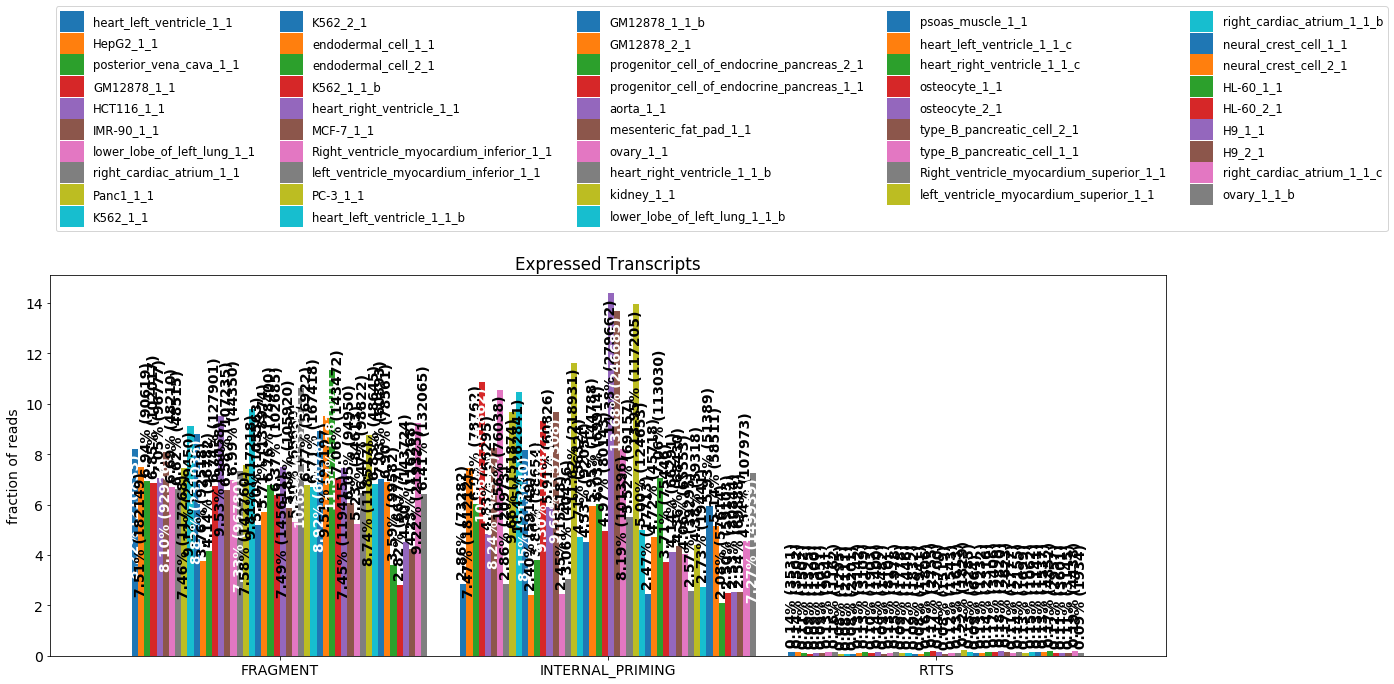

In [9]:
#plot technical artifacts for individual samples
plt.rcParams["figure.figsize"] = (20,7)
plot_bar(f_stats_sample[0],drop_categories=['MULTIEXON','NOVEL_TRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL_SPLICING' ],legend=False,rot=0, bar_width=.9,**f_stats_sample[1])  
plt.legend(fontsize='small', ncol=5,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')

## Data exploration
To explore the relation of the samples with respect to splicing we look at PCA and UMAP embeddings based on alternative splicing events.

In [10]:
#Compute alternative splicing events by finding "bubbles" in the segment graphs
splice_events=isoseq.alternative_splicing_events()

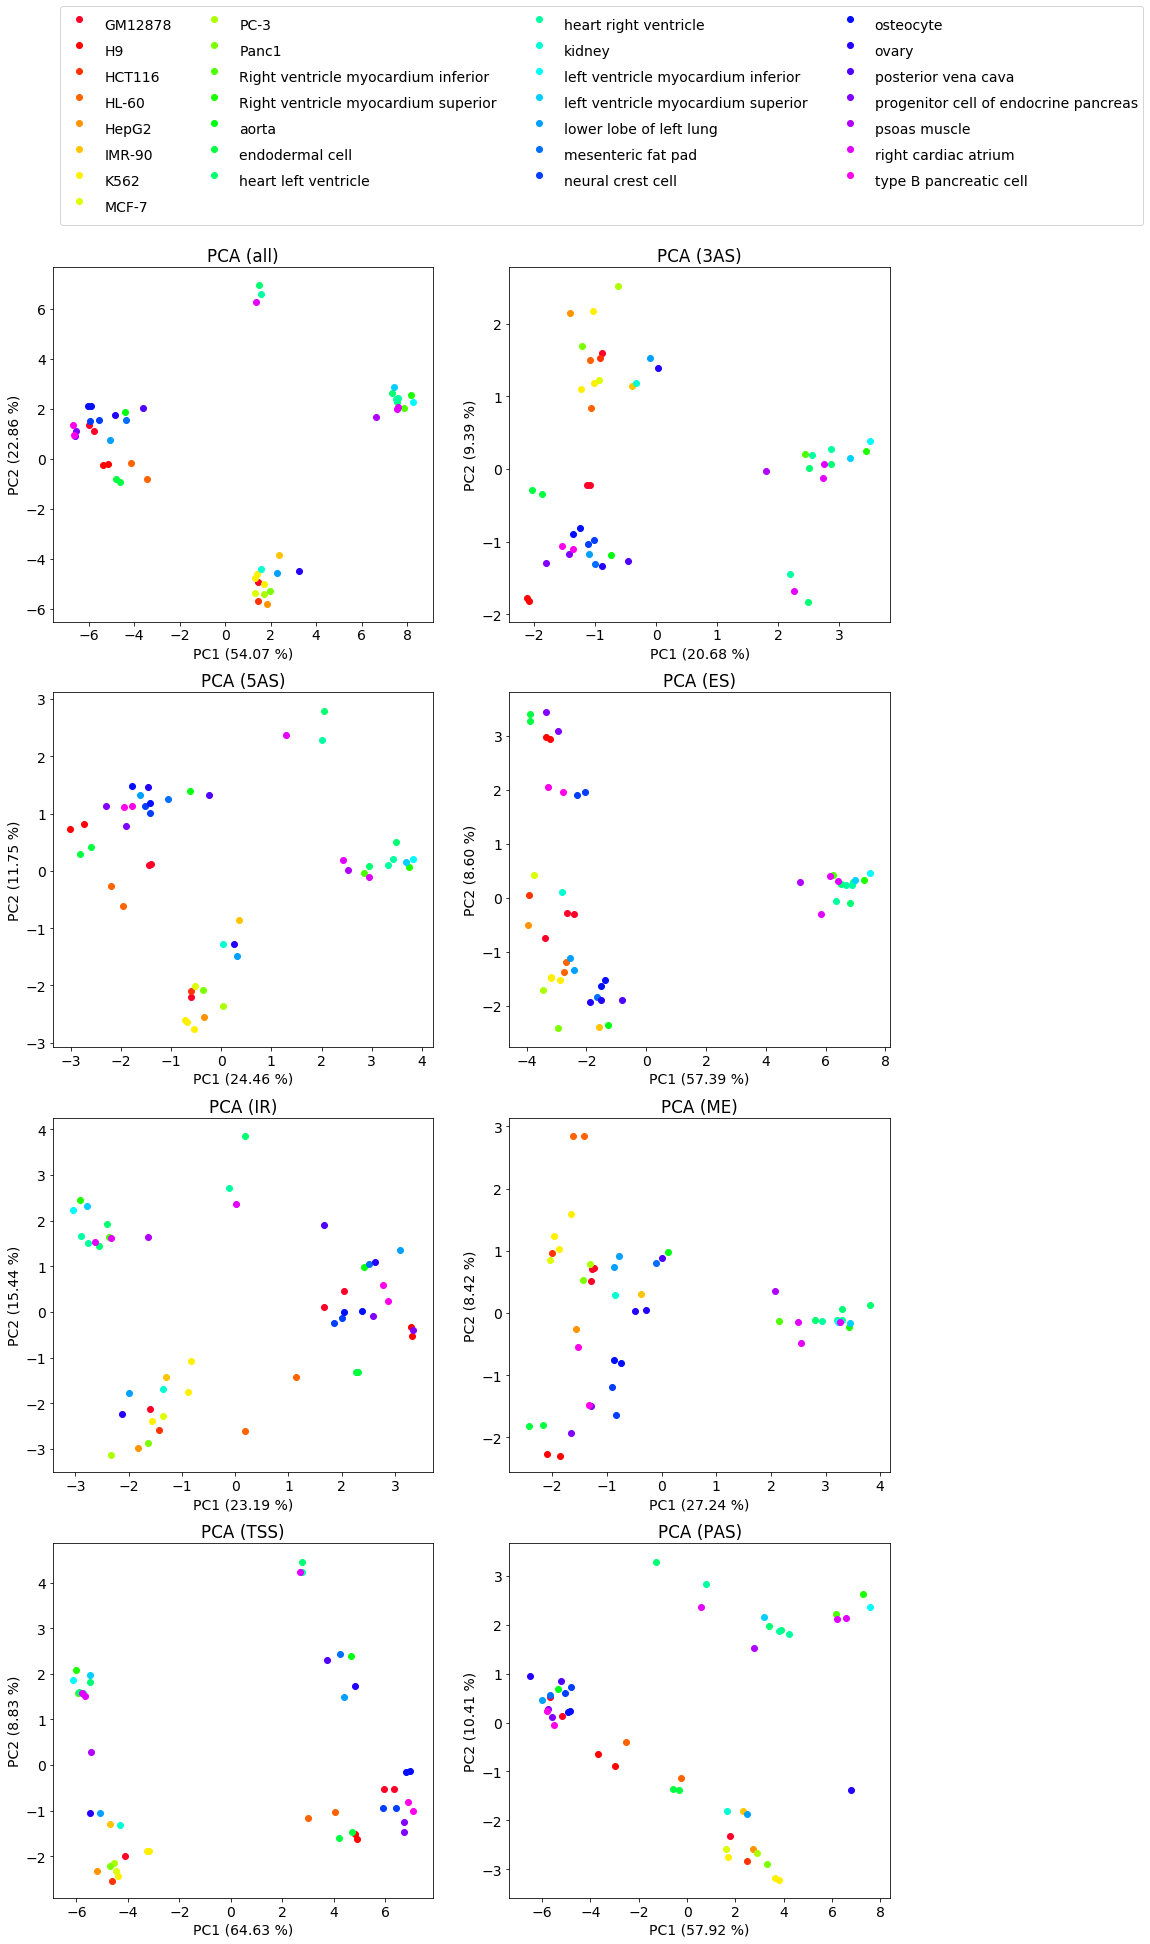

In [11]:
#plot PCA embedding
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (15,30)

pca={}

f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    pca[t]=plot_embedding(splice_events, ax=ax, labels=False, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')
#plt.tight_layout()


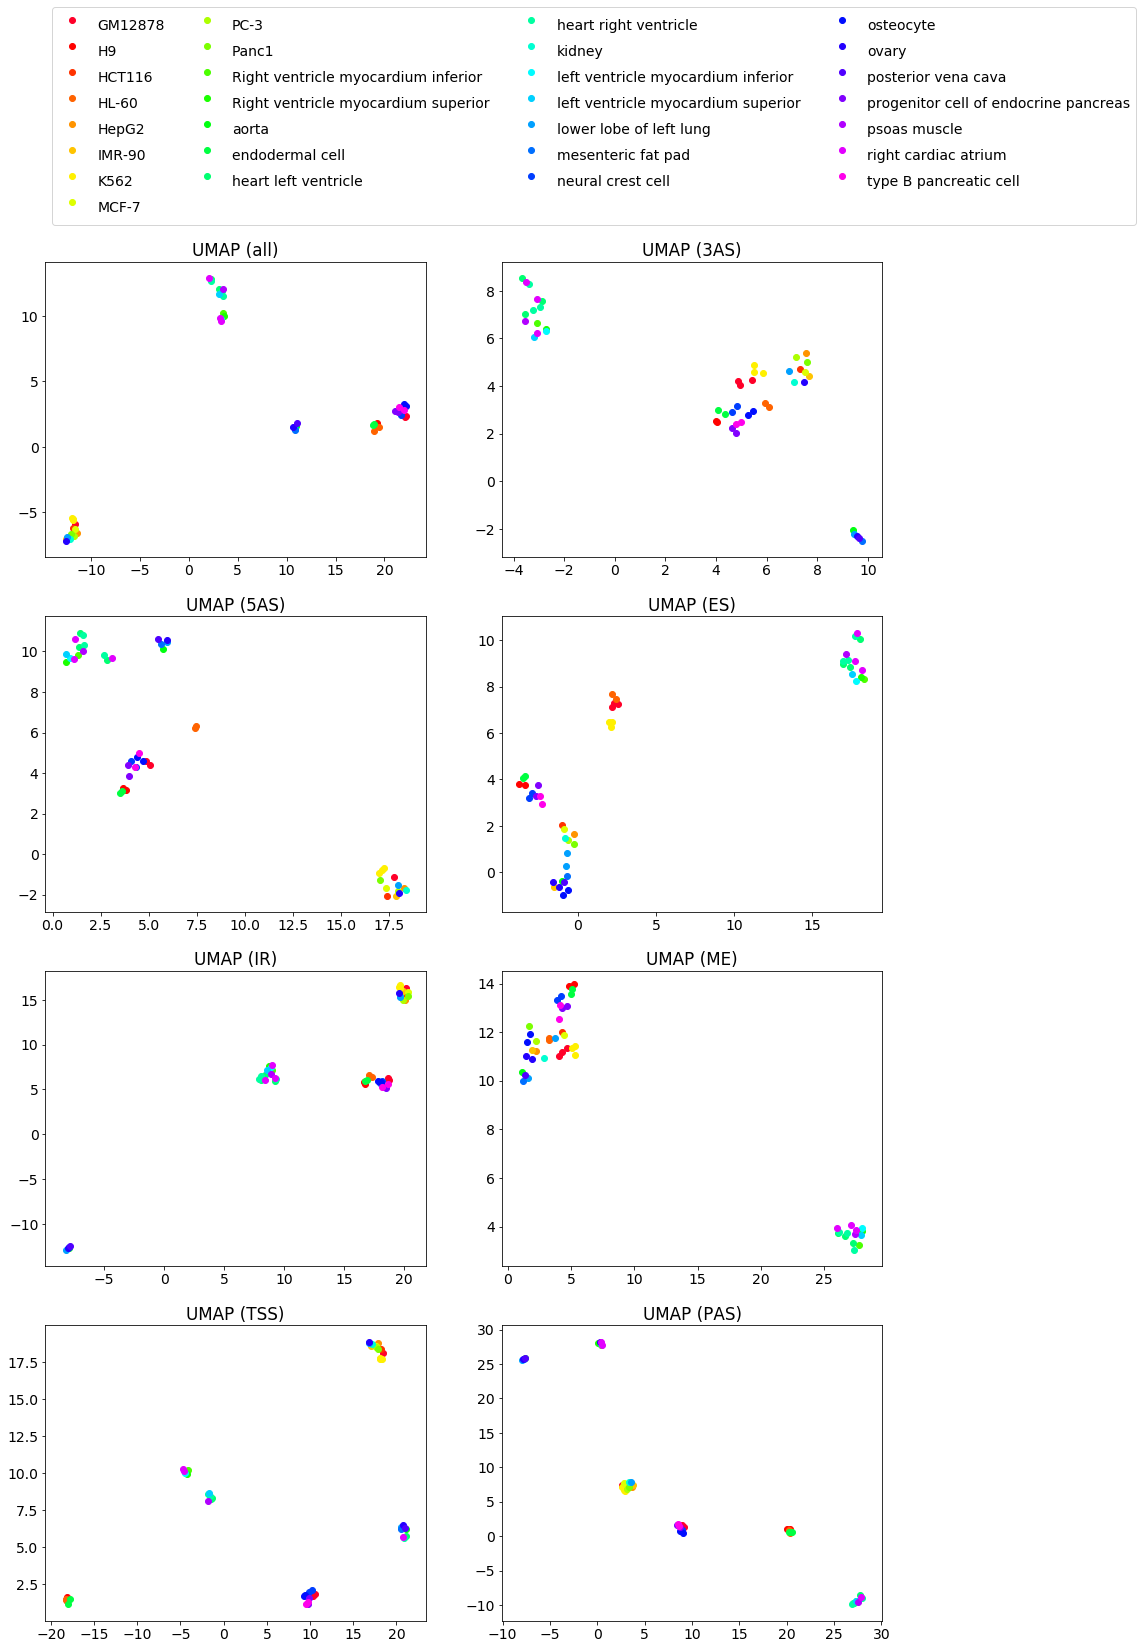

In [12]:
#plot UMAP embedding 
# the clustering of samples very much depends on the n_neighbors parameter
plt.rcParams["figure.figsize"] = (15,25)
umap={}
f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    umap[t]=plot_embedding(splice_events, method='UMAP',n_neighbors=6, ax=ax, labels=False, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=4,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')


INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples HepG2_1_1, HCT116_1_1, Panc1_1_1, K562_1_1, K562_2_1, K562_1_1_b, MCF-7_1_1, PC-3_1_1,

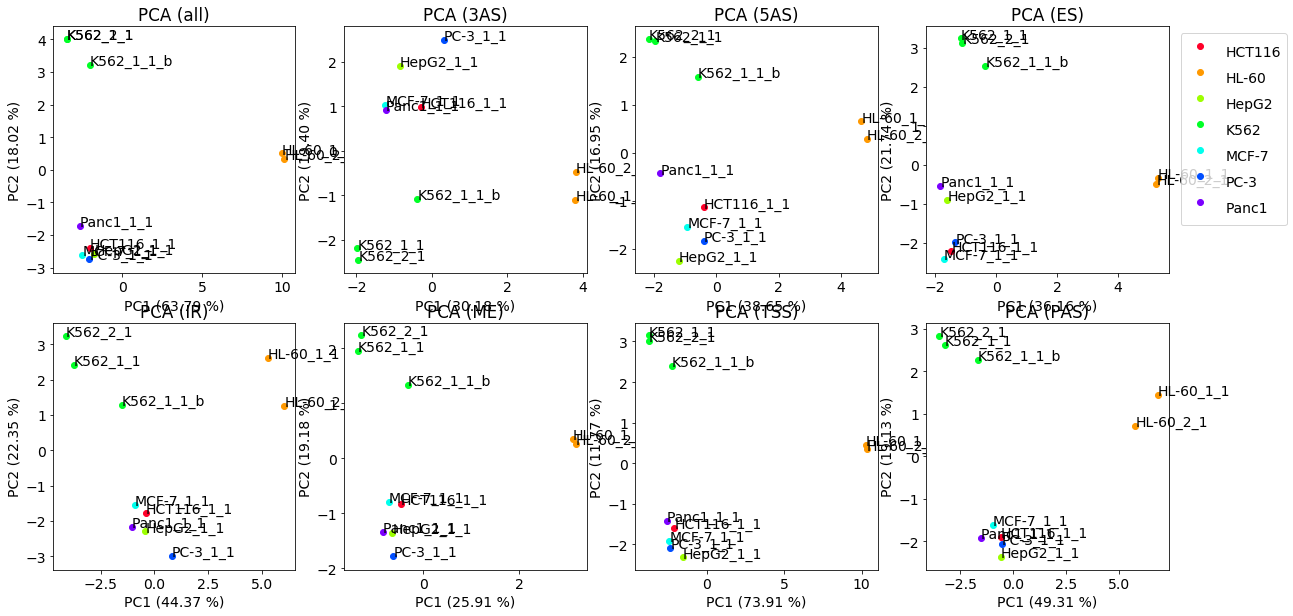

In [13]:
#plot PCA embedding of cancer cell lines only
#This seperates leukemia cell lines from carcinoma cell lines
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in karyotype['cancer']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=True, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

INFO:restricting embedding on samples heart_left_ventricle_1_1, right_cardiac_atrium_1_1, heart_right_ventricle_1_1, Right_ventricle_myocardium_inferior_1_1, left_ventricle_myocardium_inferior_1_1, heart_left_ventricle_1_1_b, heart_right_ventricle_1_1_b, heart_left_ventricle_1_1_c, heart_right_ventricle_1_1_c, Right_ventricle_myocardium_superior_1_1, left_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_b, right_cardiac_atrium_1_1_c
INFO:restricting embedding on samples heart_left_ventricle_1_1, right_cardiac_atrium_1_1, heart_right_ventricle_1_1, Right_ventricle_myocardium_inferior_1_1, left_ventricle_myocardium_inferior_1_1, heart_left_ventricle_1_1_b, heart_right_ventricle_1_1_b, heart_left_ventricle_1_1_c, heart_right_ventricle_1_1_c, Right_ventricle_myocardium_superior_1_1, left_ventricle_myocardium_superior_1_1, right_cardiac_atrium_1_1_b, right_cardiac_atrium_1_1_c
INFO:restricting embedding on samples heart_left_ventricle_1_1, right_cardiac_atrium_1_1, heart_right_ve

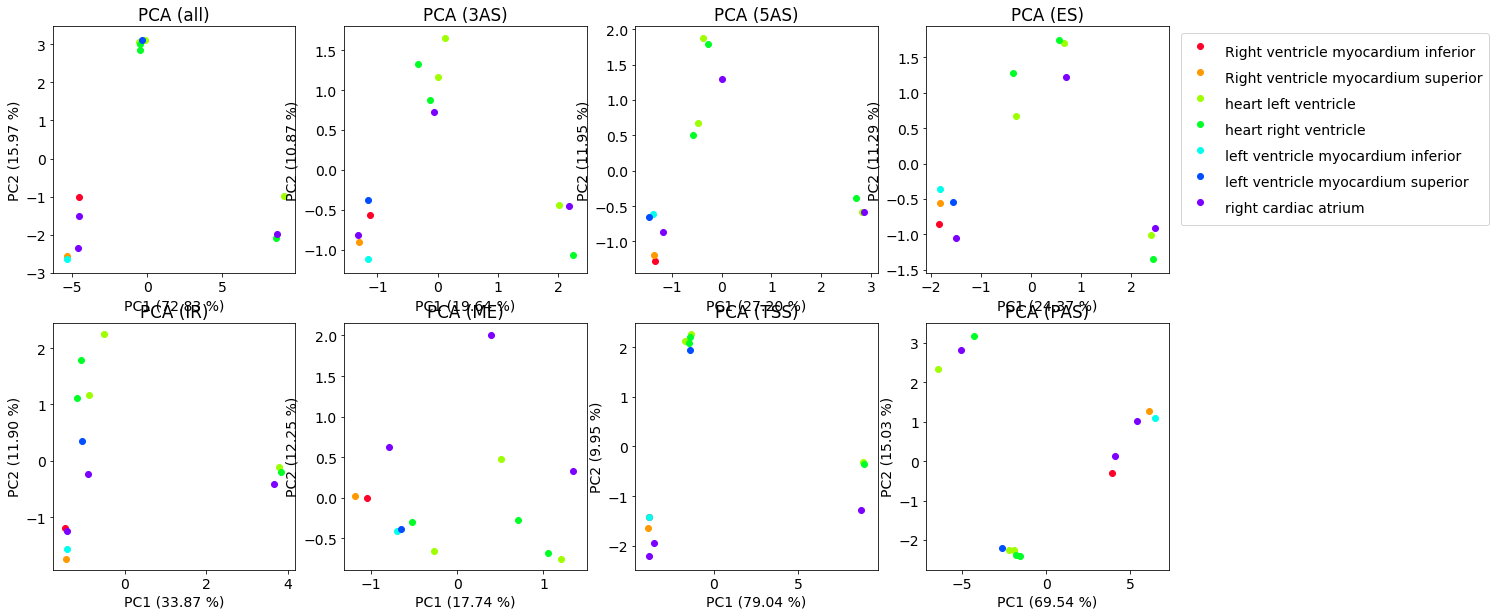

In [14]:
#plot PCA embedding of heart samples only
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in organ['heart']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=False, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

## Novel alternative splicing classification

In [15]:

cname=['FSM','ISM','NIC','NNC','novel gene']
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

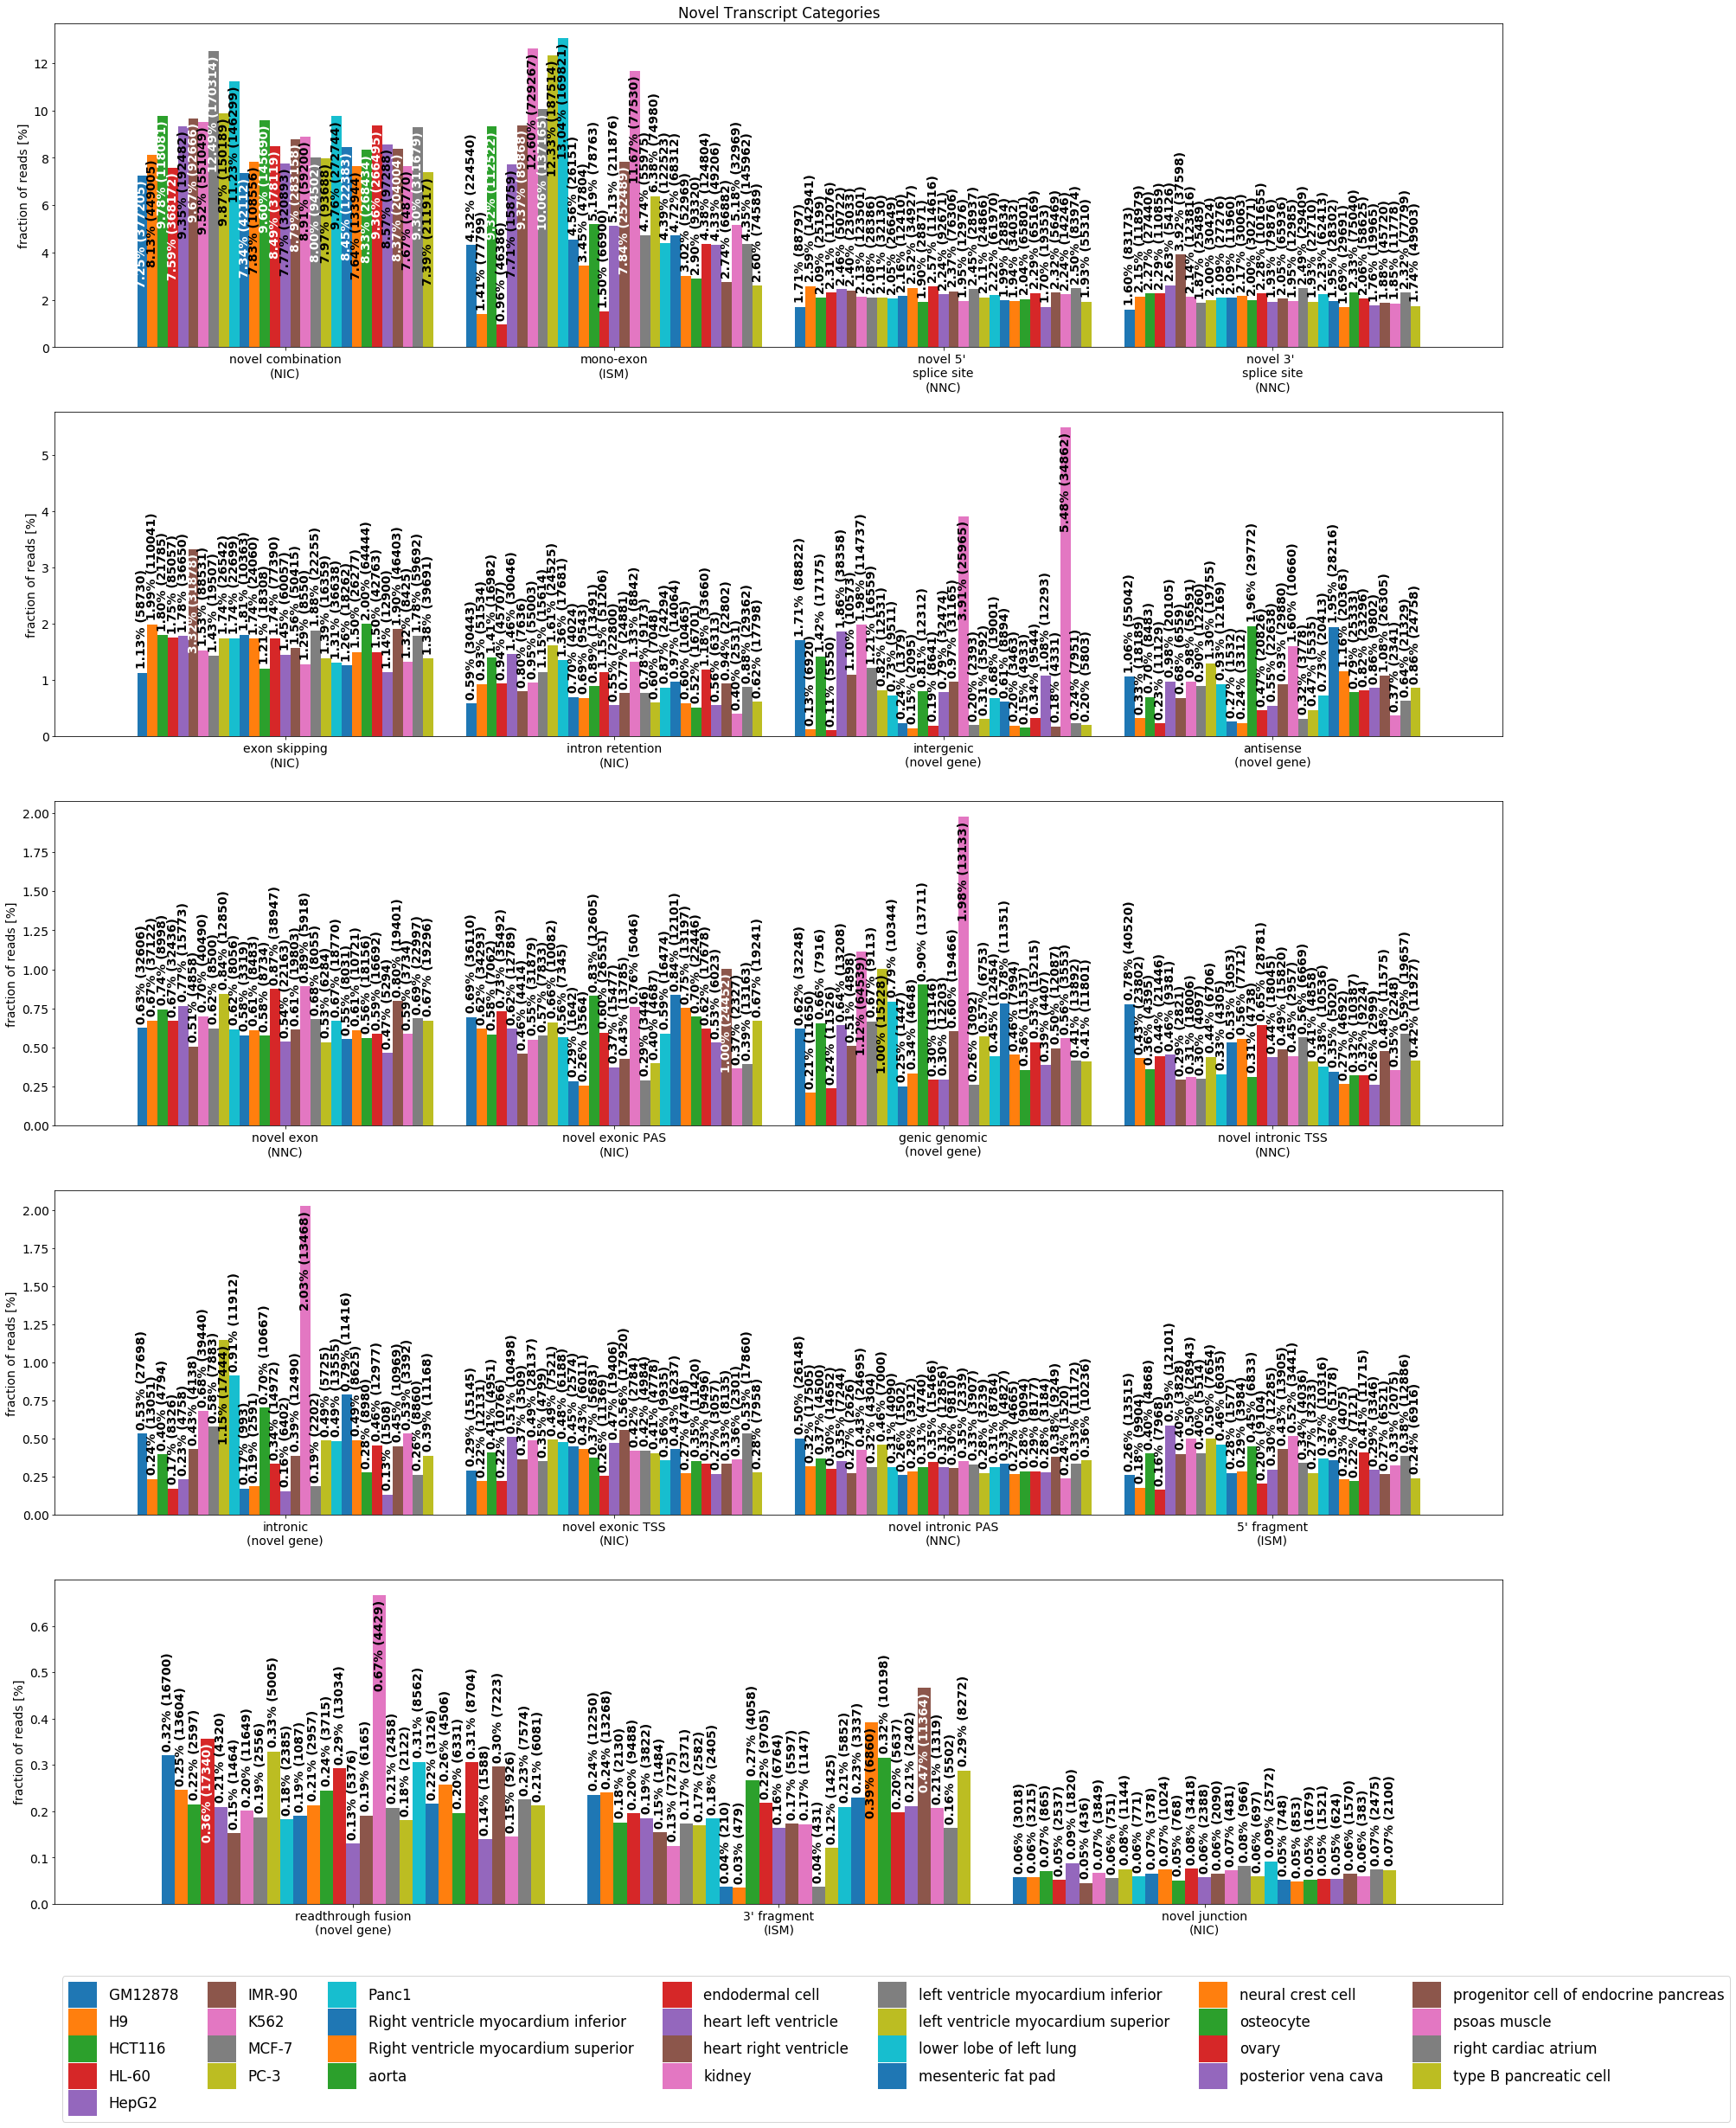

In [16]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,40)
fig, axs = plt.subplots( 5)
for i,ax in enumerate(axs):
    cat=altsplice[0][0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice[0][0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice[0][0].index if c not in cat])  
axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

In [17]:
#The same for individual samples
altsplice_sample= isoseq.altsplice_stats( weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))
altsplice_sample[0].index=altsplice_sample[0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice_sample[0].index]


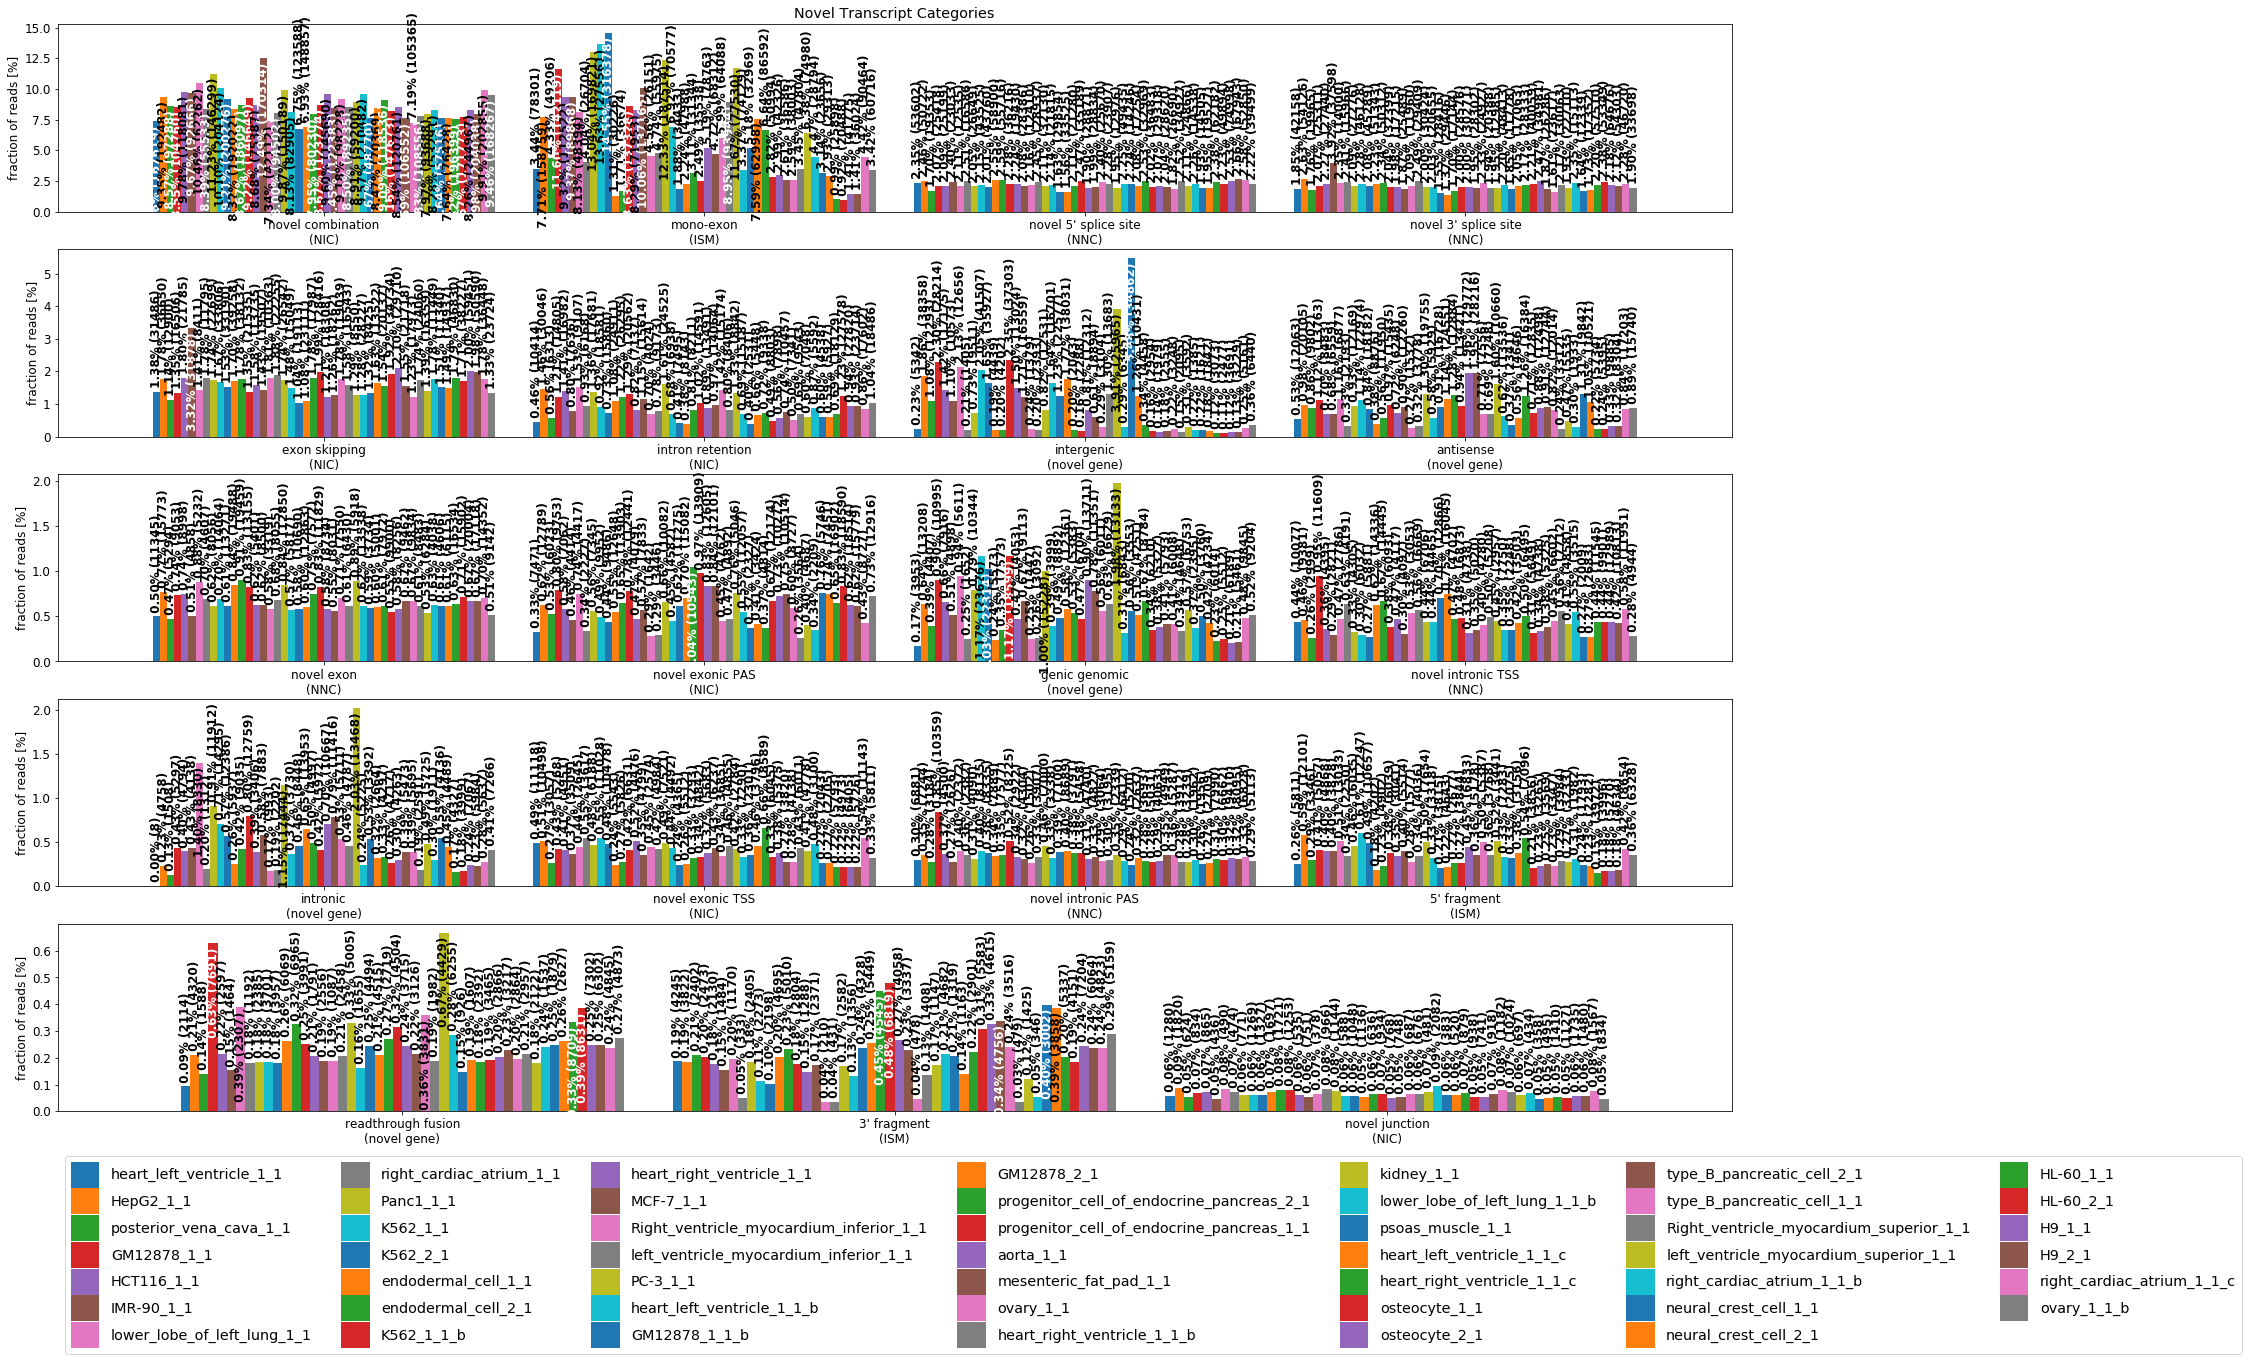

In [18]:
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots( 5)


for i,ax in enumerate(axs.flatten()):
    cat=altsplice_sample[0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice_sample[0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice_sample[0].index if c not in cat])  
handles, labels = axs[0].get_legend_handles_labels()

axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

## Differential splicing

To test for differential splicing events between groups of samples, IsoTools implements a likelihood ratio test based on beta binomial distribution. 
For each alternative event, the number of reads supporting the alternative is modeled with a binomial distribution, where the probability parmeter is beta distributed. For the null model, we fit one set of maximum likelihood parameters of the beta distribution for all samples, whereas for the alternative model, a set of parameters if fitted for each group. Under the null hypothesis, the model deviance is assumed to follow a chi2 distribution with two degrees of freedom.

Each comparision results in table of alternative splicing events, sorted by significance. 
To explore the results, we can plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
We can also look at individual examples and depict the event as a sashimi plot. 
To this end, we define a helper function, to automatically identify the relevant region and the involved junctions and make the sashimi plot:


In [19]:
#first we define a function, to depcit the results
def plot_diff_example(row, isoseq, groups):
    #sashimi plot for differential spliced genes
    plt.rcParams["figure.figsize"] = (15,10)
    #select gene object
    g=isoseq[row.gene_id]
    #make the title
    gn=list(groups)
    novel='novel' if row.novel else 'known'
    title=f'{g.name} {row.splice_type} ({novel}) FDR={row.padj:.2e}: {gn[0]}={row[gn[0]+"_PSI"]*100:.1f} vs {gn[1]}={row[gn[1]+"_PSI"]*100:.1f} PSI'
    print(title)
    start=row.start
    end=row.end
    #select the junctions of interest (which will be marked purple in the plot)
    joi=[(start,end)]
    if row.splice_type=='ME' and g.is_annotated:
        try:
            sg=g.ref_segment_graph
            n1=next(n for n in sg if n[1]==start)
            n2=next(n for n in sg if n[0]==end)
            joi={(start,sg[suc].start) for suc in n1.suc.values() if sg[suc].start<end }
            joi.update({(sg[pre].end,end) for pre in n2.pre.values() if sg[pre].end>start })
        except:
            pass
    #draw the plot for the two sample groups from the comparison
    f,axs=g.sashimi_figure(samples=groups , x_range=(start-500, end+500),junctions_of_interest=joi    )
    axs[0].set_title(title)
    fig.tight_layout()

In [20]:
from isotools.plots import plot_diff_results
#We are mostly interested in differential splicing. Alternative TSS and PAS are ignored for now. 
types_of_interest=['ES','ME','5AS','3AS']
#dict to store the results in
res={}

### Normal endodermal development
As a first example, we compare the embryonic stem cell line H9 vs in vitro derived endodermal cells.

In [21]:
diff_cmp='H9/endodermal cell'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 20 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for H9 (2) vs endodermal cell (2) using betabinom_lr test
100%|██████████| 570107/570107 [16:53<00:00, 562.57it/s] 


388 differential splice sites in 278 genes for H9 vs endodermal cell


index   gene             gene_id  chrom strand      start        end  \
0    9073   DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
14    828  CCNL2  ENSG00000221978.12   chr1      -    1390865    1393395   
15   6076   OTX2  ENSG00000165588.18  chr14      -   56802355   56805359   
22   8642   WSB1  ENSG00000109046.15  chr17      +   27306882   27309099   
32  19899  LAS1L  ENSG00000001497.18   chrX      -   65524262   65524964   
34   9074   DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
35  15643  HMGCR  ENSG00000113161.16   chr5      +   75354697   75355364   
37  16000   BRD8  ENSG00000112983.18   chr5      -  138166108  138167933   
42  15748  HARS1  ENSG00000170445.16   chr5      -  140678015  140679061   
43  12893  PRMT2  ENSG00000160310.18  chr21      +   46635763   46636895   

   splice_type  novel      padj  ...  total_PSI  total_disp  H9_1_1_H9_in_cov  \
0          5AS   True  0.063809  ...   0.597657    0.096982                57   
14         3AS  False  0.063809  ...   0.603724    0.035540               104   
15          ES  False  0.063809  ...   0.824694    0.005527              1406   
22         3AS  False  0.063809  ...   0.325741    0.033853                78   
32          ES  False  0.067091  ...   0.186298    0.009080               221   
34         3AS   True  0.067091  ...   0.552004    0.083533                60   
35          ES  False  0.067091  ...   0.774301    0.010418               433   
37          ES  False  0.067091  ...   0.641522    0.025700               122   
42         5AS  False  0.069243  ...   0.858092    0.008208               552   
43          ES  False  0.069355  ...   0.451093    0.024672               290   

    H9_1_1_H9_total_cov  H9_2_1_H9_in_cov  H9_2_1_H9_total_cov  \
0                   248                46                  235   
14                  255                87                  224   
15                 1856              1134                 1528   
22                  610                78                  565   
32                  769               190                  684   
34                  251                42                  231   
35                  654               414                  611   
37                  268               114                  235   
42                  712               491                  644   
43                  461               247                  408   

    endodermal_cell_1_1_endodermal cell_in_cov  \
0                                          216   
14                                         375   
15                                        1697   
22                                         258   
32                                          47   
34                                         119   
35                                         621   
37                                         300   
42                                         369   
43                                         191   

    endodermal_cell_1_1_endodermal cell_total_cov  \
0                                             229   
14                                            464   
15                                           1884   
22                                            523   
32                                            528   
34                                            132   
35                                            713   
37                                            370   
42                                            391   
43                                            626   

    endodermal_cell_2_1_endodermal cell_in_cov  \
0                                          236   
14                                         360   
15                                        1619   
22                                         331   
32                                          43   
34                                          84   
35                                         680   
37           

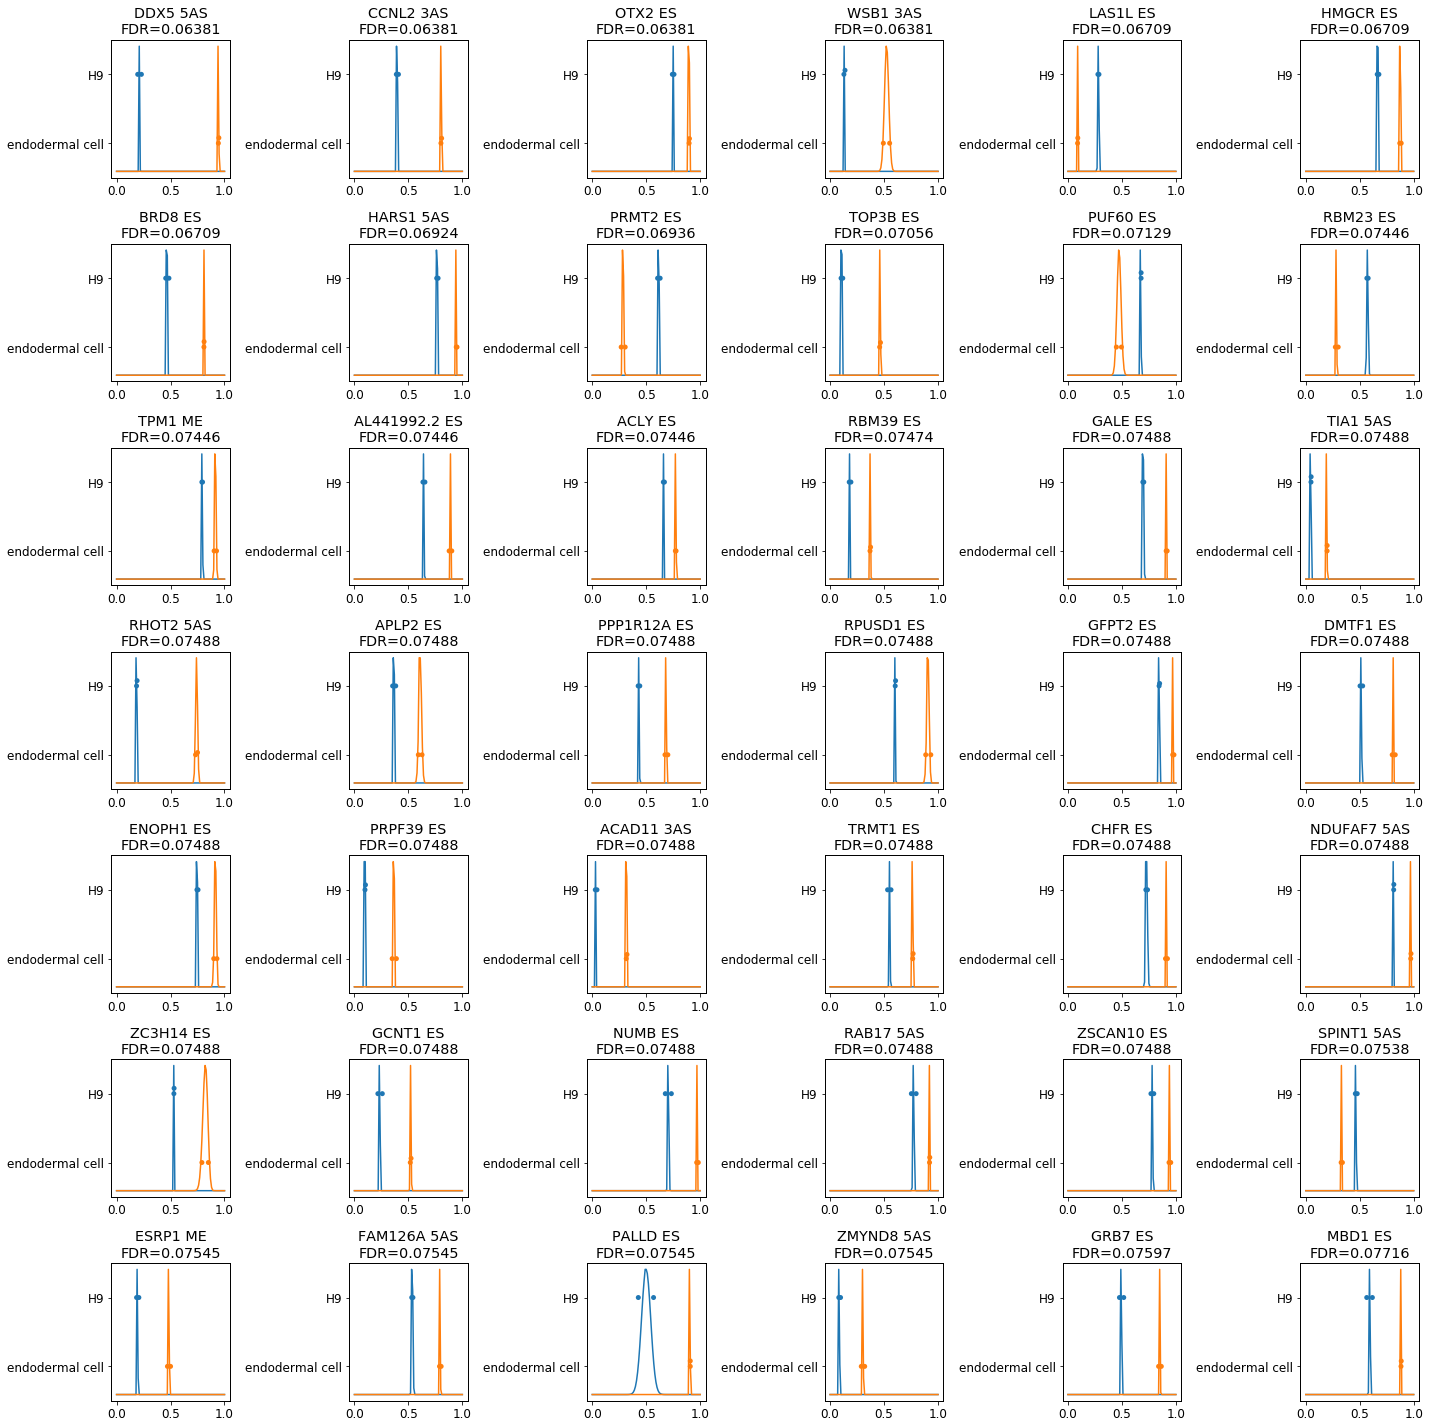

In [22]:
#plot the fitted maximum likelihood beta distributions of the alternative model for the most significant events.
plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

OTX2 ES (known) FDR=6.38e-02: H9=75.1 vs endodermal cell=89.9 PSI


NameError: name 'FuncFormatter' is not defined

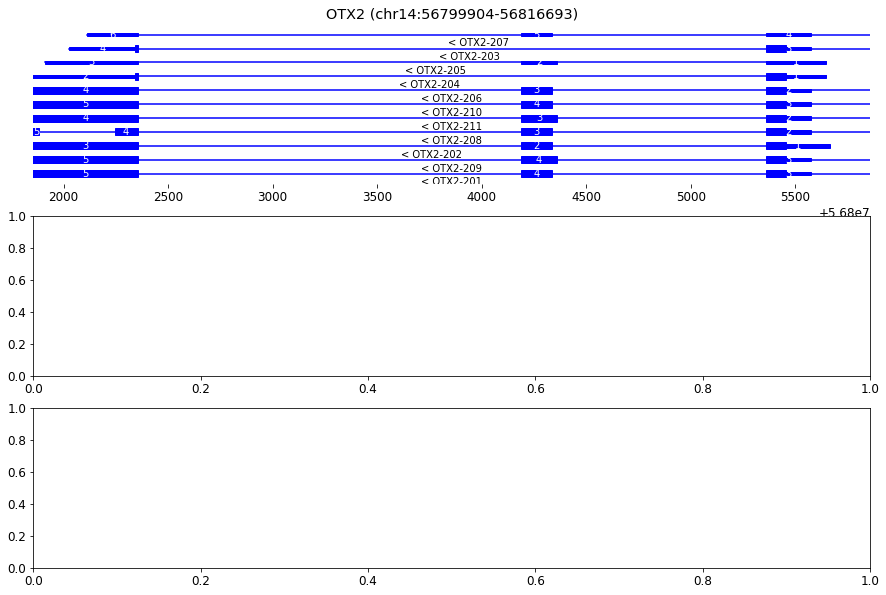

In [23]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[15]
plot_diff_example(row, isoseq, groups)

### Leukemia cell lines
Both leukemia cell lines HL-60 and K562 (should) have mutations in the splicing machinery, e.g. in the SRSF2 gene, which should lead to abberant splicing. We compare them to the B-cell derived cell line GM12878.

See Urbanski et al: Alternative-splicing defects in cancer: splicing regulators and their downstream targets, guiding the way to novel cancer therapeutics
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002934/


In [ ]:
diff_cmp='GM12878/HL-60'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#
#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

In [ ]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

In [ ]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,20)
#1) select gene of interest: 3nd row, exon skipping of EIF4A2
row=res[diff_cmp].iloc[3]
plot_diff_example(row, isoseq, groups)

In [ ]:
diff_cmp='GM12878/K562'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

In [ ]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,8),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

In [ ]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[5]
plot_diff_example(row, isoseq, groups)

In [ ]:
gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'GM12878':gr['GM12878']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

In [ ]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

In [ ]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[2]
plot_diff_example(row, isoseq, groups)

### Carcinoma cell lines
Carcinomas often feature mutations in RBM10 or deregulation of SRSF1, SRSF3 and SRSF6, each leading to specific splicing defects. 

In [ ]:

diff_cmp='Panc1/progenitor cell of endocrine pancreas'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}


#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

In [ ]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest: PSAP this looks like a missaligned exon skipping event
row=res[diff_cmp].iloc[18]
plot_diff_example(row, isoseq, groups)

In [ ]:
#all carcinoma vs normal endoderm
karyotype=isoseq.groups('karyotype')
lineage=isoseq.groups('lineage')
cell=isoseq.groups('cell')

groups={'carcinoma':[sa for sa in karyotype['cancer'] if sa in cell['epithelial cell']], 
        'normal endoderm':[sa for sa in karyotype['normal'] if sa in lineage['endoderm']]}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

In [ ]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,5),min_support=2, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

In [ ]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[1]
plot_diff_example(row, isoseq, groups)

In [ ]:
#differential splicing all leukemia vs carcinoma

gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'carcinoma':gr['Panc1']+gr['HCT116']+gr['HepG2']+gr['PC-3']+gr['MCF-7']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

In [ ]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=3, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

In [ ]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[7]
plot_diff_example(row, isoseq, groups)